In [2]:
%load_ext autoreload
%autoreload 2

In [51]:
from scipy.optimize import fmin_slsqp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
import os
import sys
from pathlib import Path
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs, low_shelf, high_shelf

## Regularization Regression
Finding a polynomial function which expresses the maximum gain for a parametric filter with given Q

In [ ]:
fc = 20 * 2**(np.log(20e3 / 20) / np.log(2) / 2)
qs = []
gains = []
for q in np.arange(min_q, max_q, 0.1):
    for gain in np.arange(1, 20, 0.1):
        fr = digital_coeffs(f, 44100, *low_shelf(fc, q, gain, fs=44100))
        max_d = np.max(np.abs(fr[1:] - fr[:-1]) / f_step)
        if max_d > 18:
            qs.append(q)
            gains.append(gain)
            break

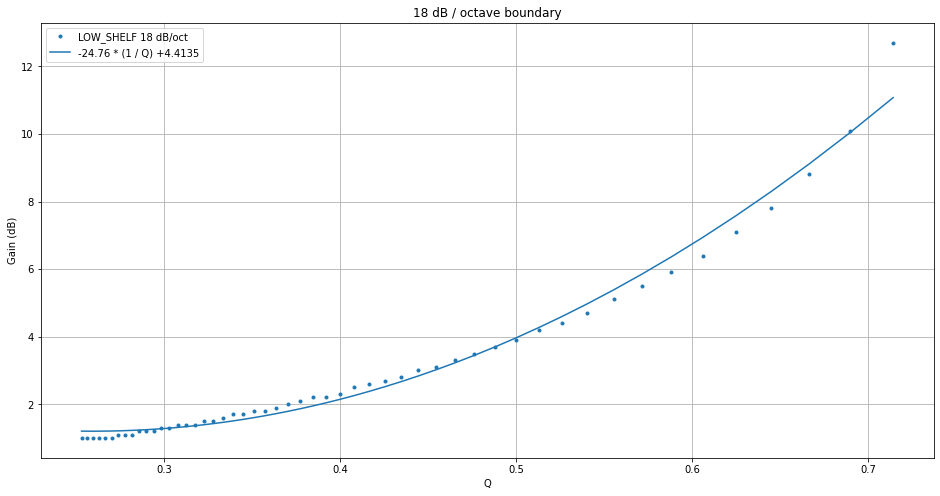

In [155]:
def plot_max_slope_boundary(filter_type, max_slope, min_q, max_q, ax):
    fc = 20 * 2**(np.log(20e3 / 20) / np.log(2) / 2)
    f = FrequencyResponse.generate_frequencies()
    f_step = np.log(f[1] / f[0]) / np.log(2)
    qs = []
    gains = []
    for q in np.arange(min_q, max_q, 0.05):
        for gain in np.arange(1, 20, 0.1):
            if filter_type == 'LOW_SHELF':
                fr = digital_coeffs(f, 44100, *low_shelf(fc, q, gain, fs=44100))
            elif filter_type == 'PEAKING':
                fr = digital_coeffs(f, 44100, *peaking(fc, q, gain, fs=44100))
            elif filter_type == 'HIGH_SHELF':
                fr = digital_coeffs(f, 44100, *high_shelf(fc, q, gain, fs=44100))
            max_d = np.max(np.abs(fr[1:] - fr[:-1]) / f_step)
            if max_d > max_slope:
                qs.append(q)
                gains.append(gain)
                break
    qs = np.array(qs)
    gains = np.array(gains)
    
    p = np.polynomial.Polynomial.fit(1 / qs, gains, 2)
    p = p.convert()
    est = p(1 / qs)

    c = ax.plot(1 / qs, gains, '.', label=f'{filter_type} {max_slope} dB/oct')
    ax.plot(1 / qs, est, color=c[0].get_color(), label=f'{p.coef[1]:.2f} * (1 / Q) {"+" if p.coef[0] >= 0 else "-"}{np.abs(p.coef[0]):.4f}')
    ax.grid()
    ax.set_ylabel('Gain (dB)')
    ax.set_xlabel('Q')
    ax.legend()
    ax.set_title(f'{d_threshold} dB / octave boundary')

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 8)
#plot_max_slope_boundary('PEAKING', 18, 0.18, 9, ax)
plot_max_slope_boundary('LOW_SHELF', 18, 0.4, 4, ax)
#plot_max_slope_boundary('HIGH_SHELF', 18, 0.4, 0.7, ax)
plt.show()

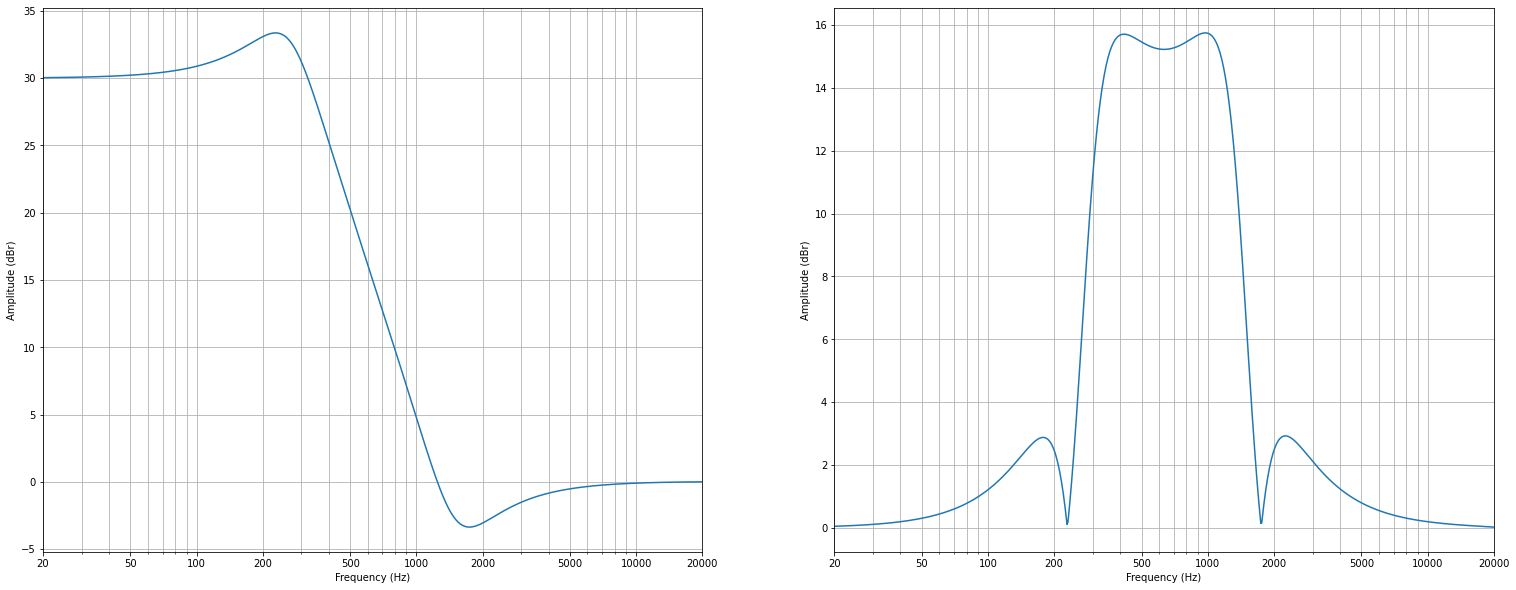

In [144]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(26, 10)
FrequencyResponse.init_plot(fig=fig, ax=axs[0])
FrequencyResponse.init_plot(fig=fig, ax=axs[1])
fr = digital_coeffs(f, 44100, *low_shelf(fc, 1.4, 30, fs=44100))
axs[0].plot(f, fr)
axs[1].plot(f[1:], np.abs(fr[1:] - fr[:-1]) / f_step)

In [60]:
-0.09503189270199464 + 20.575128011847003 * (1 / 4)

5.048750110259756

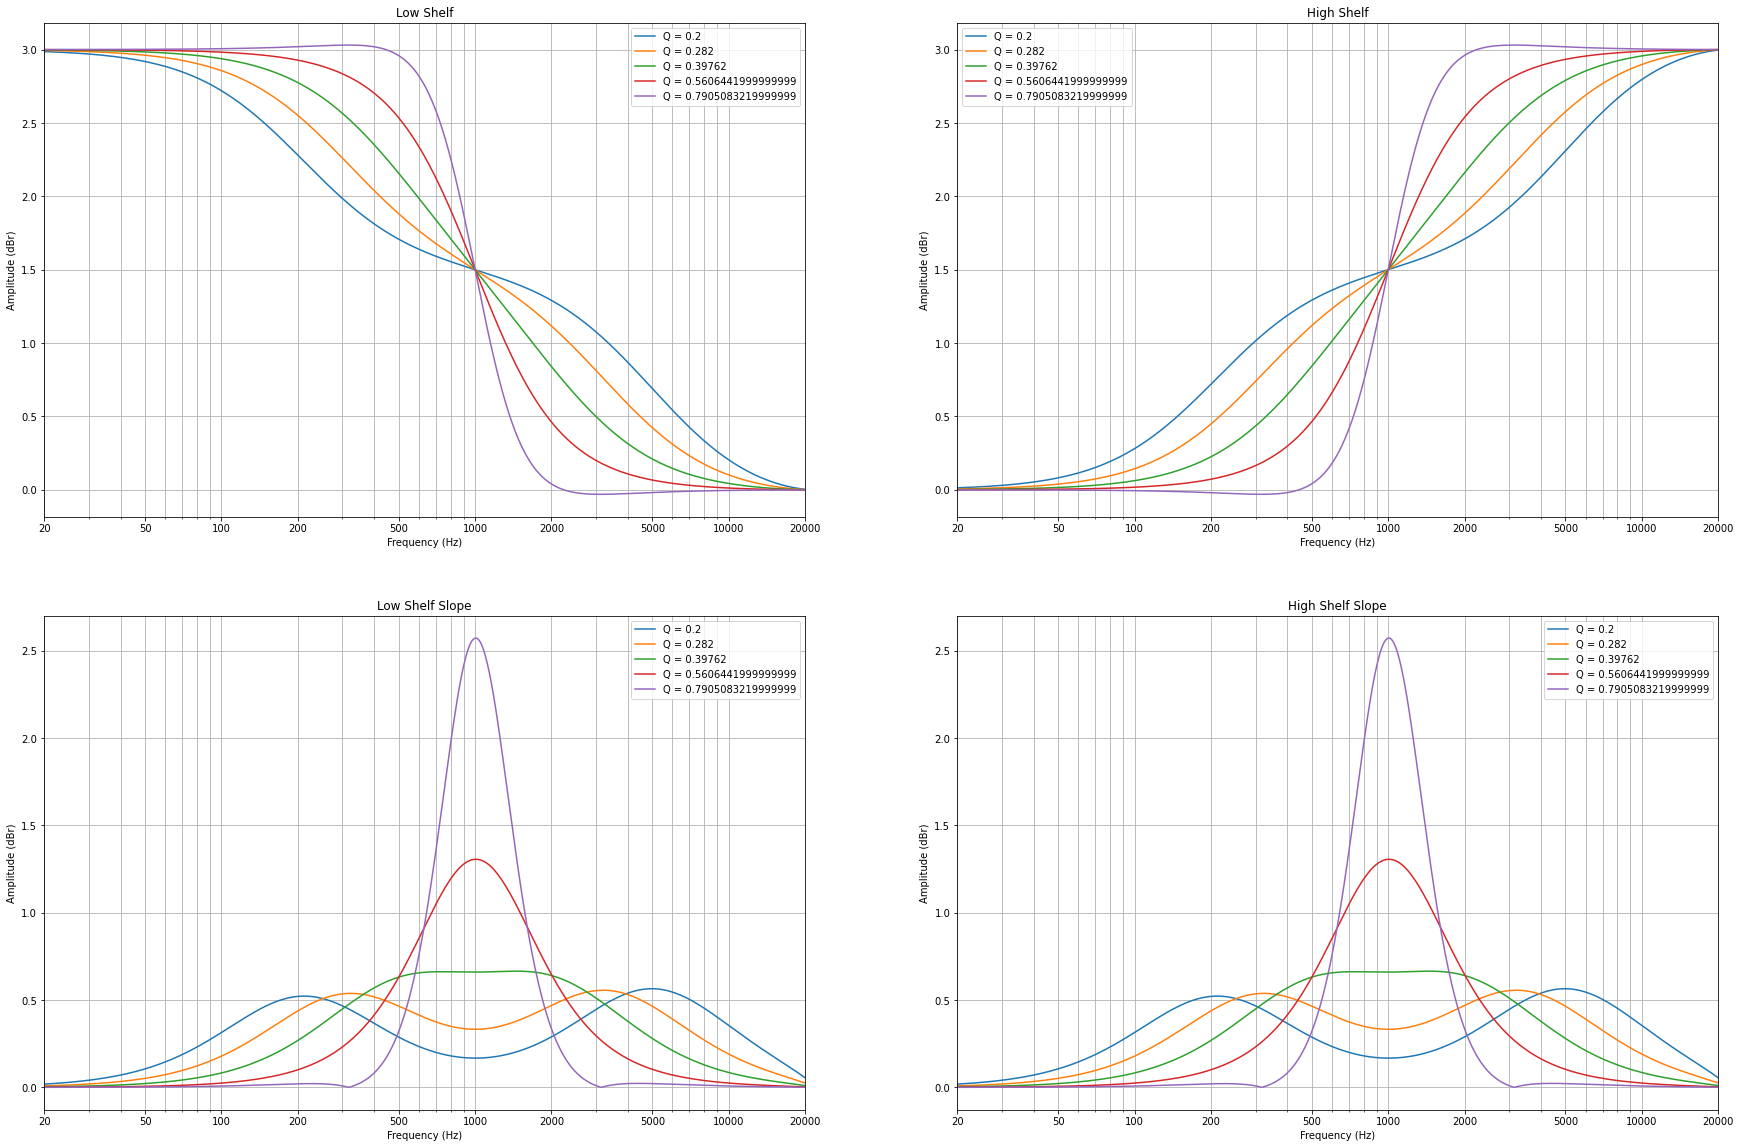

In [95]:
f = FrequencyResponse.generate_frequencies()
f_step = np.log2(f[1] / f[0])
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(30, 20)
FrequencyResponse.init_plot(fig=fig, ax=axs[0, 0])
FrequencyResponse.init_plot(fig=fig, ax=axs[0, 1])
FrequencyResponse.init_plot(fig=fig, ax=axs[1, 0])
FrequencyResponse.init_plot(fig=fig, ax=axs[1, 1])
for q in [0.2 * 1.41**i for i in range(5)]:
    fr = digital_coeffs(f, 44100, *low_shelf(1000, q, 3, fs=44100))
    axs[0, 0].plot(f, fr, label=f'Q = {q}')
    axs[1, 0].plot(f[1:], np.abs(fr[1:] - fr[:-1]) / f_step, label=f'Q = {q}')
    fr = digital_coeffs(f, 44100, *high_shelf(1000, q, 3, fs=44100))
    axs[0, 1].plot(f, fr, label=f'Q = {q}')
    axs[1, 1].plot(f[1:], np.abs(fr[1:] - fr[:-1]) / f_step, label=f'Q = {q}')
axs[0, 0].set_title('Low Shelf')
axs[0, 0].legend()
axs[0, 1].set_title('High Shelf')
axs[0, 1].legend()
axs[1, 0].set_title('Low Shelf Slope')
axs[1, 0].legend()
axs[1, 1].set_title('High Shelf Slope')
axs[1, 1].legend()
plt.show()

## Q and Gain to Max Slope

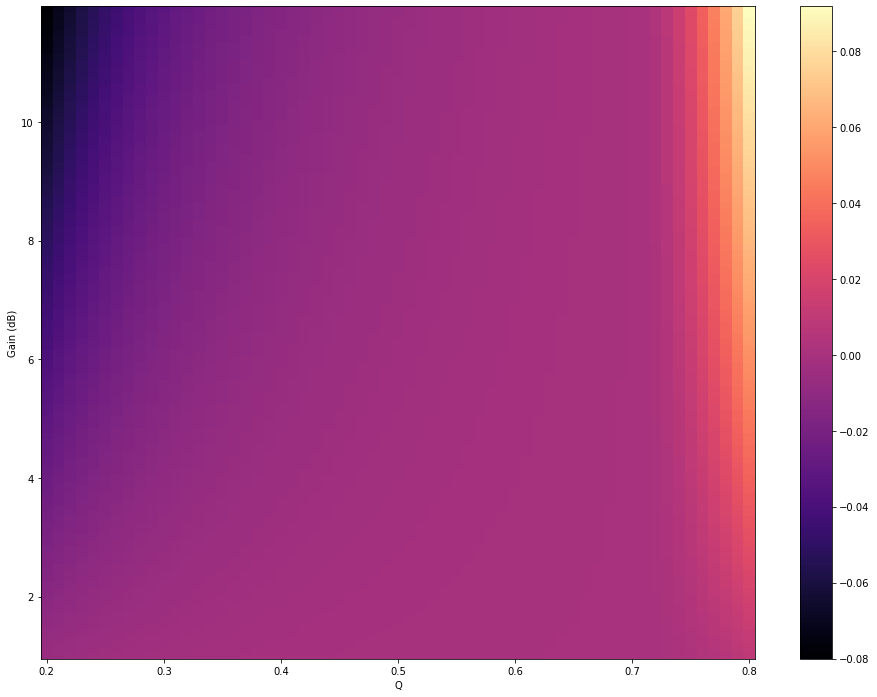

In [120]:
fc = 20 * 2**(np.log(20e3 / 20) / np.log(2) / 2)
q = np.arange(0.2, 0.8, 0.01)
gain = np.arange(1, 12, 0.1)
f = FrequencyResponse.generate_frequencies()
f_step = np.log2(f[1] / f[0])
max_d = []
for g in gain:
    frs = digital_coeffs(f, 44100, *low_shelf(fc, q, g, fs=48000))
    max_d.append([np.max((fr[1:] - fr[:-1]) / f_step) for fr in frs])
max_d = np.array(max_d)
q, gain = np.meshgrid(q, gain)

fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
c = ax.pcolormesh(q, gain, max_d, cmap='magma')
qss = []
ests = []
ps = []
for dmax in range(6, 54, 6):
    qs = np.array([q[0, min(np.sum(row < dmax), max_d.shape[1] - 1)] for row in max_d])
    #p = np.polynomial.Polynomial.fit(1 / qs, gain[:, 0], 1).convert()
    #ps.append(p)
    #est = p(1 / qs)
    #qss.append(qs)
    #ests.append(est)
    #ax.plot(qs, est, color='C2')
ax.set_xlabel('Q')
ax.set_ylabel('Gain (dB)')
fig.colorbar(c, ax=ax)
plt.show()

In [39]:
print('6 dB', ests[0][np.argmin(np.abs(qss[0] - 4))])
print('12 dB', ests[1][np.argmin(np.abs(qss[1] - 4))])
print('18 dB', ests[2][np.argmin(np.abs(qss[2] - 4))])
print('24 dB', ests[3][np.argmin(np.abs(qss[3] - 4))])

6 dB 1.7823884821323999
12 dB 3.2126941862060714
18 dB 4.6766685875145795
24 dB 6.231537229962925


In [44]:
print(f'6 dB / oct @ 4Q: {ps[0](1 / 4):.2f} dB')
print(f'12 dB / oct @ 4Q: {ps[1](1 / 4):.2f} dB')
print(f'18 dB / oct @ 4Q: {ps[2](1 / 4):.2f} dB')
print(f'24 dB / oct @ 4Q: {ps[4](1 / 4):.2f} dB')

6 dB / oct @ 4Q: 1.77 dB
12 dB / oct @ 4Q: 3.19 dB
18 dB / oct @ 4Q: 4.65 dB
24 dB / oct @ 4Q: 7.99 dB


## Comparing Regularized and Unregularized

In [9]:
def compare_regularization(fp, n, plot=True):
    fr = FrequencyResponse.read_from_csv(fp)
    ix = np.sum(fr.frequency < 10e3)
    if plot:
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(30, 12)
    times = []
    rmses = []
    max_q_ds = []
    
    for i, regularize in zip(range(0, 2), [False, True]):
        t = time()
        filters, n_filters, max_gains = fr.optimize_parametric_eq(n, fs=44100, regularize_band=False, regularize_q=regularize)
        times.append(time() - t)
        rmse = np.sqrt(np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr.parametric_eq[:ix]))))
        rmses.append(rmse)
        
        fc, q, gain = np.split(filters, 3, axis=1)
        
        gain_limit = -0.09503189270199464 + 20.575128011847003 * (1 / q)
        max_q_ds.append(np.max(18 * gain / gain_limit))
        
        if plot:
            #plot_filters(fr, filters, fig, axs[i])
            fr.plot_graph(fig=fig, ax=axs[i], raw=False, smoothed=False, error=False, error_smoothed=False, target=False, equalization=True, equalized=False, parametric_eq=True, fixed_band_eq=False, show=False)
            axs[i].set_title(f'Regularize = {regularize}, RMSE = {rmse:.2f} dB, Ref RMSE = {ref_rmse:.2f} dB')
        
    if plot:
        y_lim = axs[0].get_ylim() + axs[1].get_ylim()
        axs[0].set_ylim([np.min(y_lim), np.max(y_lim)])
        axs[1].set_ylim([np.min(y_lim), np.max(y_lim)])
        plt.show()
    return times, rmses, max_q_ds

In [81]:
n = [5, 5]
data = []
i = 0
for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
    times, rmses, max_q_ds = compare_regularization(fp, n, plot=False)
    data.append([
        times[0],
        times[1],
        times[1] - times[0],
        times[1] / times[0],
        rmses[0],
        rmses[1],
        rmses[1] - rmses[0],
        rmses[1] / rmses[0],
        max_q_ds[0],
        max_q_ds[1],
        max_q_ds[1] - max_q_ds[0],
        max_q_ds[1] / max_q_ds[0],
    ])
    i += 1
    if i > 200:
        break

In [82]:
df = pd.DataFrame(data, columns=['t (unreg)', 't (reg)', 't (diff)', 't (ratio)', 'RMSE (unreg)', 'RMSE (reg)', 'RMSE (diff)', 'RMSE (ratio)', 'Max Q^ (unreg)', 'Max Q^ (reg)', 'Max Q^ (diff)', 'Max Q^ (ratio)'])
df

,t (unreg),t (reg),t (diff),t (ratio),RMSE (unreg),RMSE (reg),RMSE (diff),RMSE (ratio),Max Q^ (unreg),Max Q^ (reg),Max Q^ (diff),Max Q^ (ratio)
0,0.507114,0.583131,0.076017,1.149901,0.668826,0.668826,0.000000,1.000000,14.277146,14.277146,0.000000,1.000000
1,0.469106,0.652146,0.183040,1.390190,0.526285,0.531193,0.004908,1.009326,8.176183,8.500074,0.323891,1.039614
2,0.560126,0.640337,0.080211,1.143201,0.600015,0.599817,-0.000199,0.999669,15.822521,15.820697,-0.001824,0.999885
3,0.598203,0.644572,0.046369,1.077514,0.505538,0.505538,0.000000,1.000000,12.804984,12.804984,0.000000,1.000000
4,0.641144,0.721162,0.080018,1.124806,0.484568,0.484568,0.000000,1.000000,13.751091,13.751091,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.552123,0.633142,0.081019,1.146741,0.749271,0.752090,0.002819,1.003762,16.595572,16.584639,-0.010934,0.999341
197,0.511115,0.547123,0.036008,1.070450,0.705082,0.687011,-0.018070,0.974372,57.932728,17.382773,-40.549955,0.300051
198,0.430097,0.615138,0.185041,1.430232,0.723335,0.666949,-0.056387,0.922046,84.476033,17.474051,-67.001983,0.206852
199,0.625141,0.651146,0.026005,1.041599,0.770653,0.807866,0.037213,1.048287,105.165180,17.364012,-87.801168,0.165112


In [83]:
df.describe()

,t (unreg),t (reg),t (diff),t (ratio),RMSE (unreg),RMSE (reg),RMSE (diff),RMSE (ratio),Max Q^ (unreg),Max Q^ (reg),Max Q^ (diff),Max Q^ (ratio)
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.528951,0.602044,0.073092,1.143680,0.564793,0.568764,0.003971,1.010902,17.172065,10.944117,-6.227948,0.913127
std,0.100628,0.109824,0.047325,0.092508,0.128985,0.130657,0.056105,0.106270,20.019509,4.850372,17.375182,0.278532
min,0.193043,0.220049,-0.124029,0.795378,0.269487,0.269487,-0.206009,0.723747,0.718994,0.718994,-88.969232,0.161639
25%,0.472106,0.543122,0.056013,1.131960,0.471424,0.474299,0.000000,1.000000,6.845059,6.976210,-0.373486,0.953575
50%,0.538120,0.617139,0.076017,1.147410,0.546502,0.547511,0.000000,1.000000,10.787638,10.966930,0.000000,1.000000
75%,0.611430,0.679153,0.092020,1.161525,0.643216,0.657482,0.000373,1.000635,16.595572,16.397804,0.000000,1.000000
max,0.672151,0.772177,0.288064,1.627450,1.103068,1.103068,0.402574,1.875211,106.122868,17.497588,8.869135,2.048954


In [20]:
df.quantile(0.95, 0)

t (unreg)          0.644322
t (reg)            0.737616
t (diff)           0.180491
t (ratio)          1.400473
RMSE (unreg)       0.863416
RMSE (reg)         0.879336
RMSE (diff)        0.099534
RMSE (ratio)       1.168902
Max Q^ (unreg)    48.711572
Max Q^ (reg)      16.045640
Max Q^ (diff)      3.038908
Max Q^ (ratio)     1.355517
Name: 0.95, dtype: float64

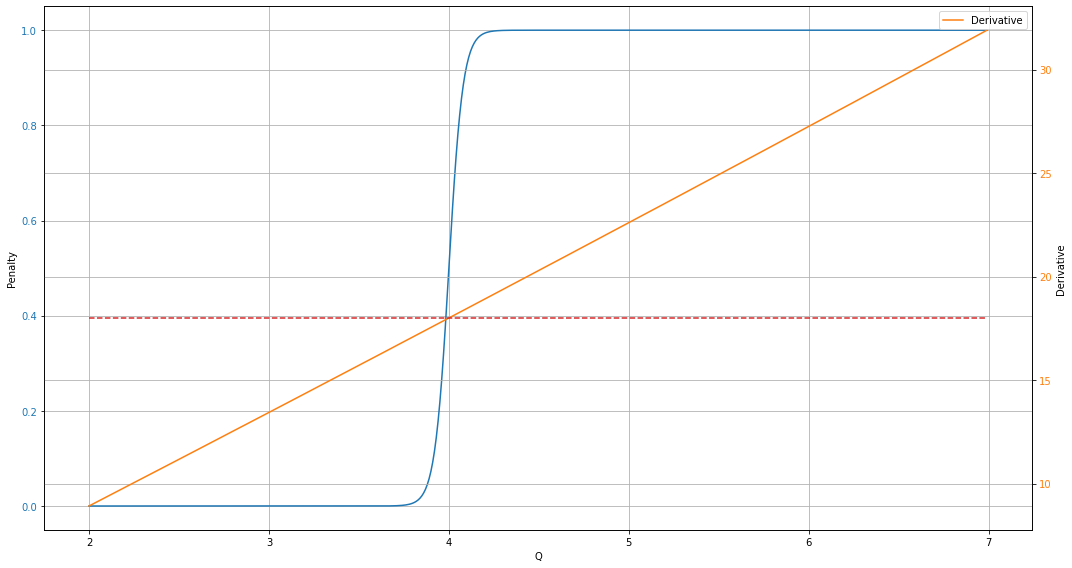

In [77]:
q = np.arange(2, 7, 0.01)
gain = 5.048750110259756
gain_limit = -0.09503189270199464 + 20.575128011847003 * (1 / q)
d = 18 * gain / gain_limit
x = gain / gain_limit - 1
sharpness_penalties = 1 / (1 + np.e ** (-x * 100))

fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(q, sharpness_penalties, color='C0')
ax1.set_xlabel('Q')
ax1.set_ylabel('Penalty')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(q, d, color='C1', label='Derivative')
ax2.plot(q, np.ones(q.shape) * 18, '--', color='C3')
ax2.set_ylabel('Derivative')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.legend()
ax2.grid()

fig.tight_layout()
plt.show()

In [72]:
5 / 5 - 1

0.0

In [73]:
1 / (1 + np.e ** (-0.0 * 50))

0.5